In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import numpy as np

In [2]:
ctc = sc.read_h5ad('ctc_heterogeneity.h5ad')
X = ctc.X

In [3]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cophenet


def compute_cophenetic(W_matrix):
    """
    给定 W 矩阵，计算共识矩阵和 CCC
    """
    consensus_matrix = np.zeros((W_matrix.shape[0], W_matrix.shape[0]))

    for i in range(W_matrix.shape[0]):
        for j in range(W_matrix.shape[0]):
            consensus_matrix[i, j] = np.dot(W_matrix[i], W_matrix[j]) / (
                np.linalg.norm(W_matrix[i]) * np.linalg.norm(W_matrix[j])
            )

    # 构建距离矩阵和树状聚类
    dist = 1 - consensus_matrix
    np.fill_diagonal(dist, 0)
    linkage_matrix = linkage(squareform(dist), method='average')
    ccc, _ = cophenet(linkage_matrix, squareform(dist))
    return ccc

def sparsity(x):
    """Hoyer's sparsity measure (0: dense, 1: sparse)"""
    if np.linalg.norm(x, 1) == 0:
        return 0
    n = len(x)
    return (np.sqrt(n) - np.linalg.norm(x, 1)/np.linalg.norm(x, 2)) / (np.sqrt(n) - 1)


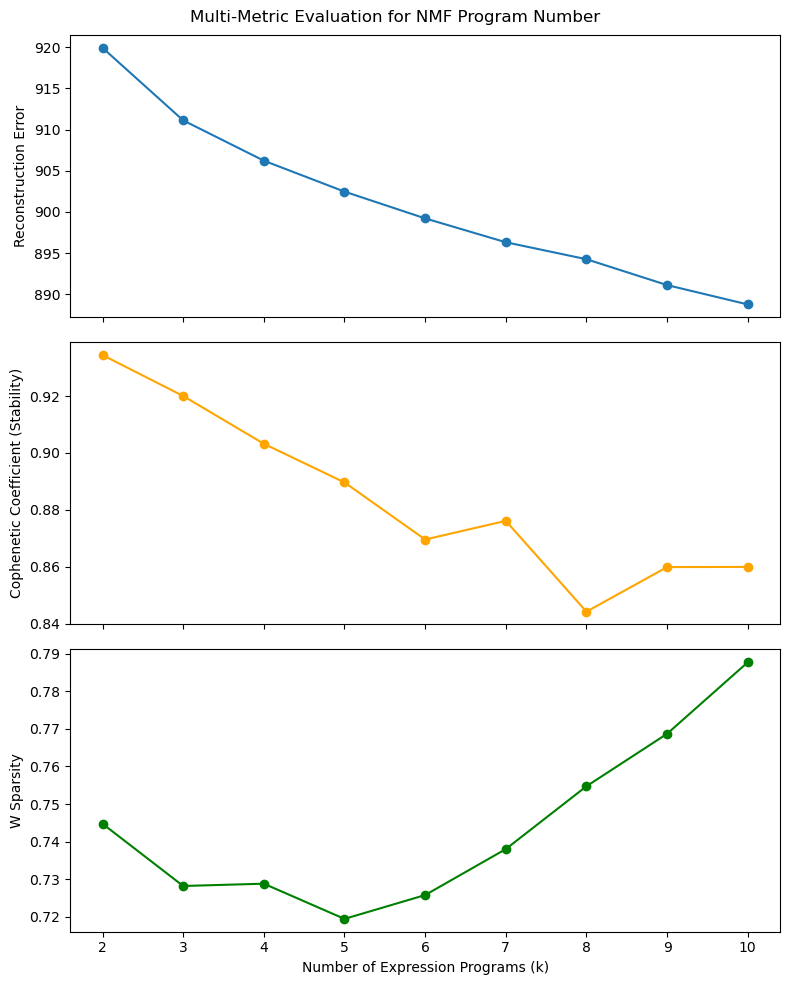

In [4]:
components_range = range(2, 11)
recons_err, cophen_scores, sparsities = [], [], []

for n in components_range:
    nmf_model = NMF(n_components=n, init="nndsvd", random_state=0, max_iter=2000)
    W = nmf_model.fit_transform(X)
    H = nmf_model.components_

    # error
    recons_err.append(nmf_model.reconstruction_err_)
    # coefficient
    ccc = compute_cophenetic(W)
    cophen_scores.append(ccc)
    # sparsity
    sparsities.append(np.mean([sparsity(row) for row in W]))


# plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

ax[0].plot(components_range, recons_err, marker='o')
ax[0].set_ylabel("Reconstruction Error")

ax[1].plot(components_range, cophen_scores, marker='o', color='orange')
ax[1].set_ylabel("Cophenetic Coefficient (Stability)")

ax[2].plot(components_range, sparsities, marker='o', color='green')
ax[2].set_ylabel("W Sparsity")

plt.xlabel("Number of Expression Programs (k)")
plt.suptitle("Multi-Metric Evaluation for NMF Program Number")
plt.tight_layout()
plt.show()

In [34]:
# the besk number of programs is 5
nmf_model = NMF(n_components=3, init='nndsvda', random_state=0, max_iter=2000)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

ctc.obsm["X_nmf"] = W
ctc.uns["nmf_H"] = H

genes = ctc.var_names
H_df = pd.DataFrame(H, columns=genes)
top_genes_dict = {
    f"Program_{i+1}": H_df.iloc[i].sort_values(ascending=False).head(50).index.tolist()
    for i in range(H.shape[0])
}

In [35]:
import gseapy as gp

results = {}
for name, genes in top_genes_dict.items():
    enr = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2025', 'GO_Molecular_Function_2025', 'GO_Cellular_Component_2025'],
                     organism='Human',
                     outdir=None)
    results[name] = enr.results[['Term', 'Adjusted P-value', 'Adjusted P-value', 'Genes']]
    enr.results.to_csv(f'/mnt/c/Users/ouyangkang/Desktop/enrichment_new_{name}.csv')

In [38]:
results['Program_3']

,Term,Adjusted P-value,Adjusted P-value,Genes
0,Regulation of Cell-Matrix Adhesion (GO:0001952),0.010560,0.010560,PEAK1;CDH13;UTRN;MAP4K4
1,Regulation of Myeloid Leukocyte Differentiatio...,0.032613,0.032613,QKI;FOXP1
2,Positive Regulation of Cell-Matrix Adhesion (G...,0.032613,0.032613,CDH13;UTRN;MAP4K4
3,Rac Protein Signal Transduction (GO:0016601),0.109068,0.109068,ELMO1;CDH13
4,Negative Regulation of RNA Biosynthetic Proces...,0.109068,0.109068,MAGI1;ZEB1;DACH1;MECOM;PLCB1;FOXP1
...,...,...,...,...
637,Intracellular Organelle Lumen (GO:0070013),0.740734,0.740734,PPP3CA;SYNE2
638,Golgi Membrane (GO:0000139),0.753115,0.753115,EXT1
639,Neuron Projection (GO:0043005),0.795715,0.795715,CDH13
640,Endoplasmic Reticulum Membrane (GO:0005789),0.895158,0.895158,EXT1


In [36]:
for i in range(W.shape[1]):
    ctc.obs[f"Program_{i+1}"] = W[:, i]

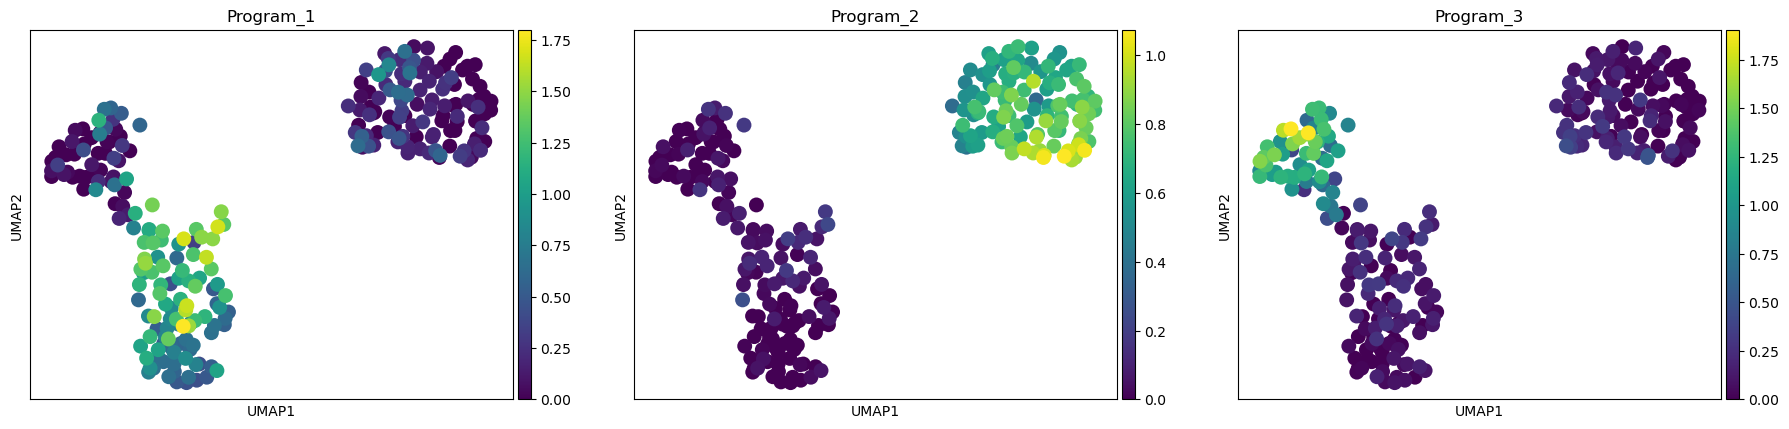

In [37]:
sc.pl.umap(ctc, color=['Program_1', 'Program_2', 'Program_3'])

In [29]:
for i in top_genes_dict.values():
    print(len(i))

20
20
20


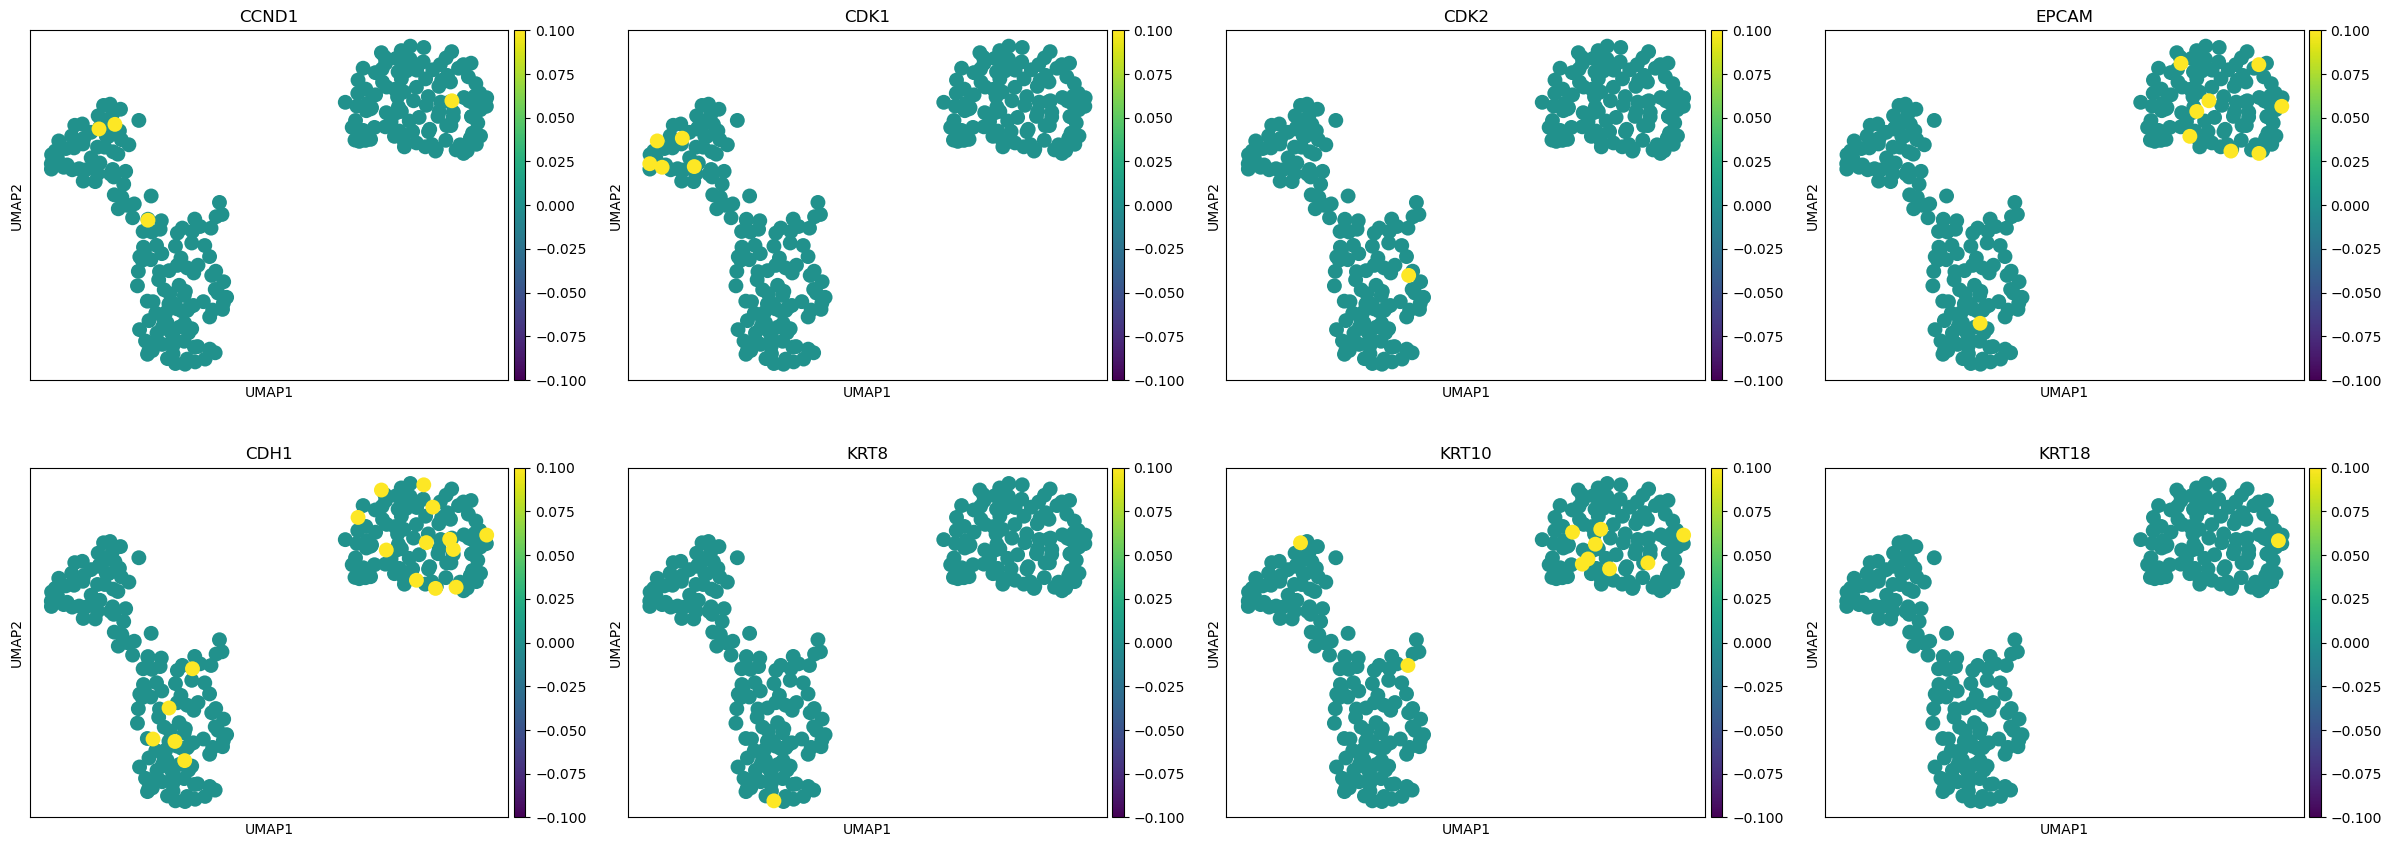

In [39]:
met_genes = ['CCND1', 'CDK1', 'CDK2', 'EPCAM', 'CDH1', 'KRT8', 'KRT10', 'KRT18']
sc.pl.umap(ctc, color=met_genes, vmax='p80', vmin='p10')

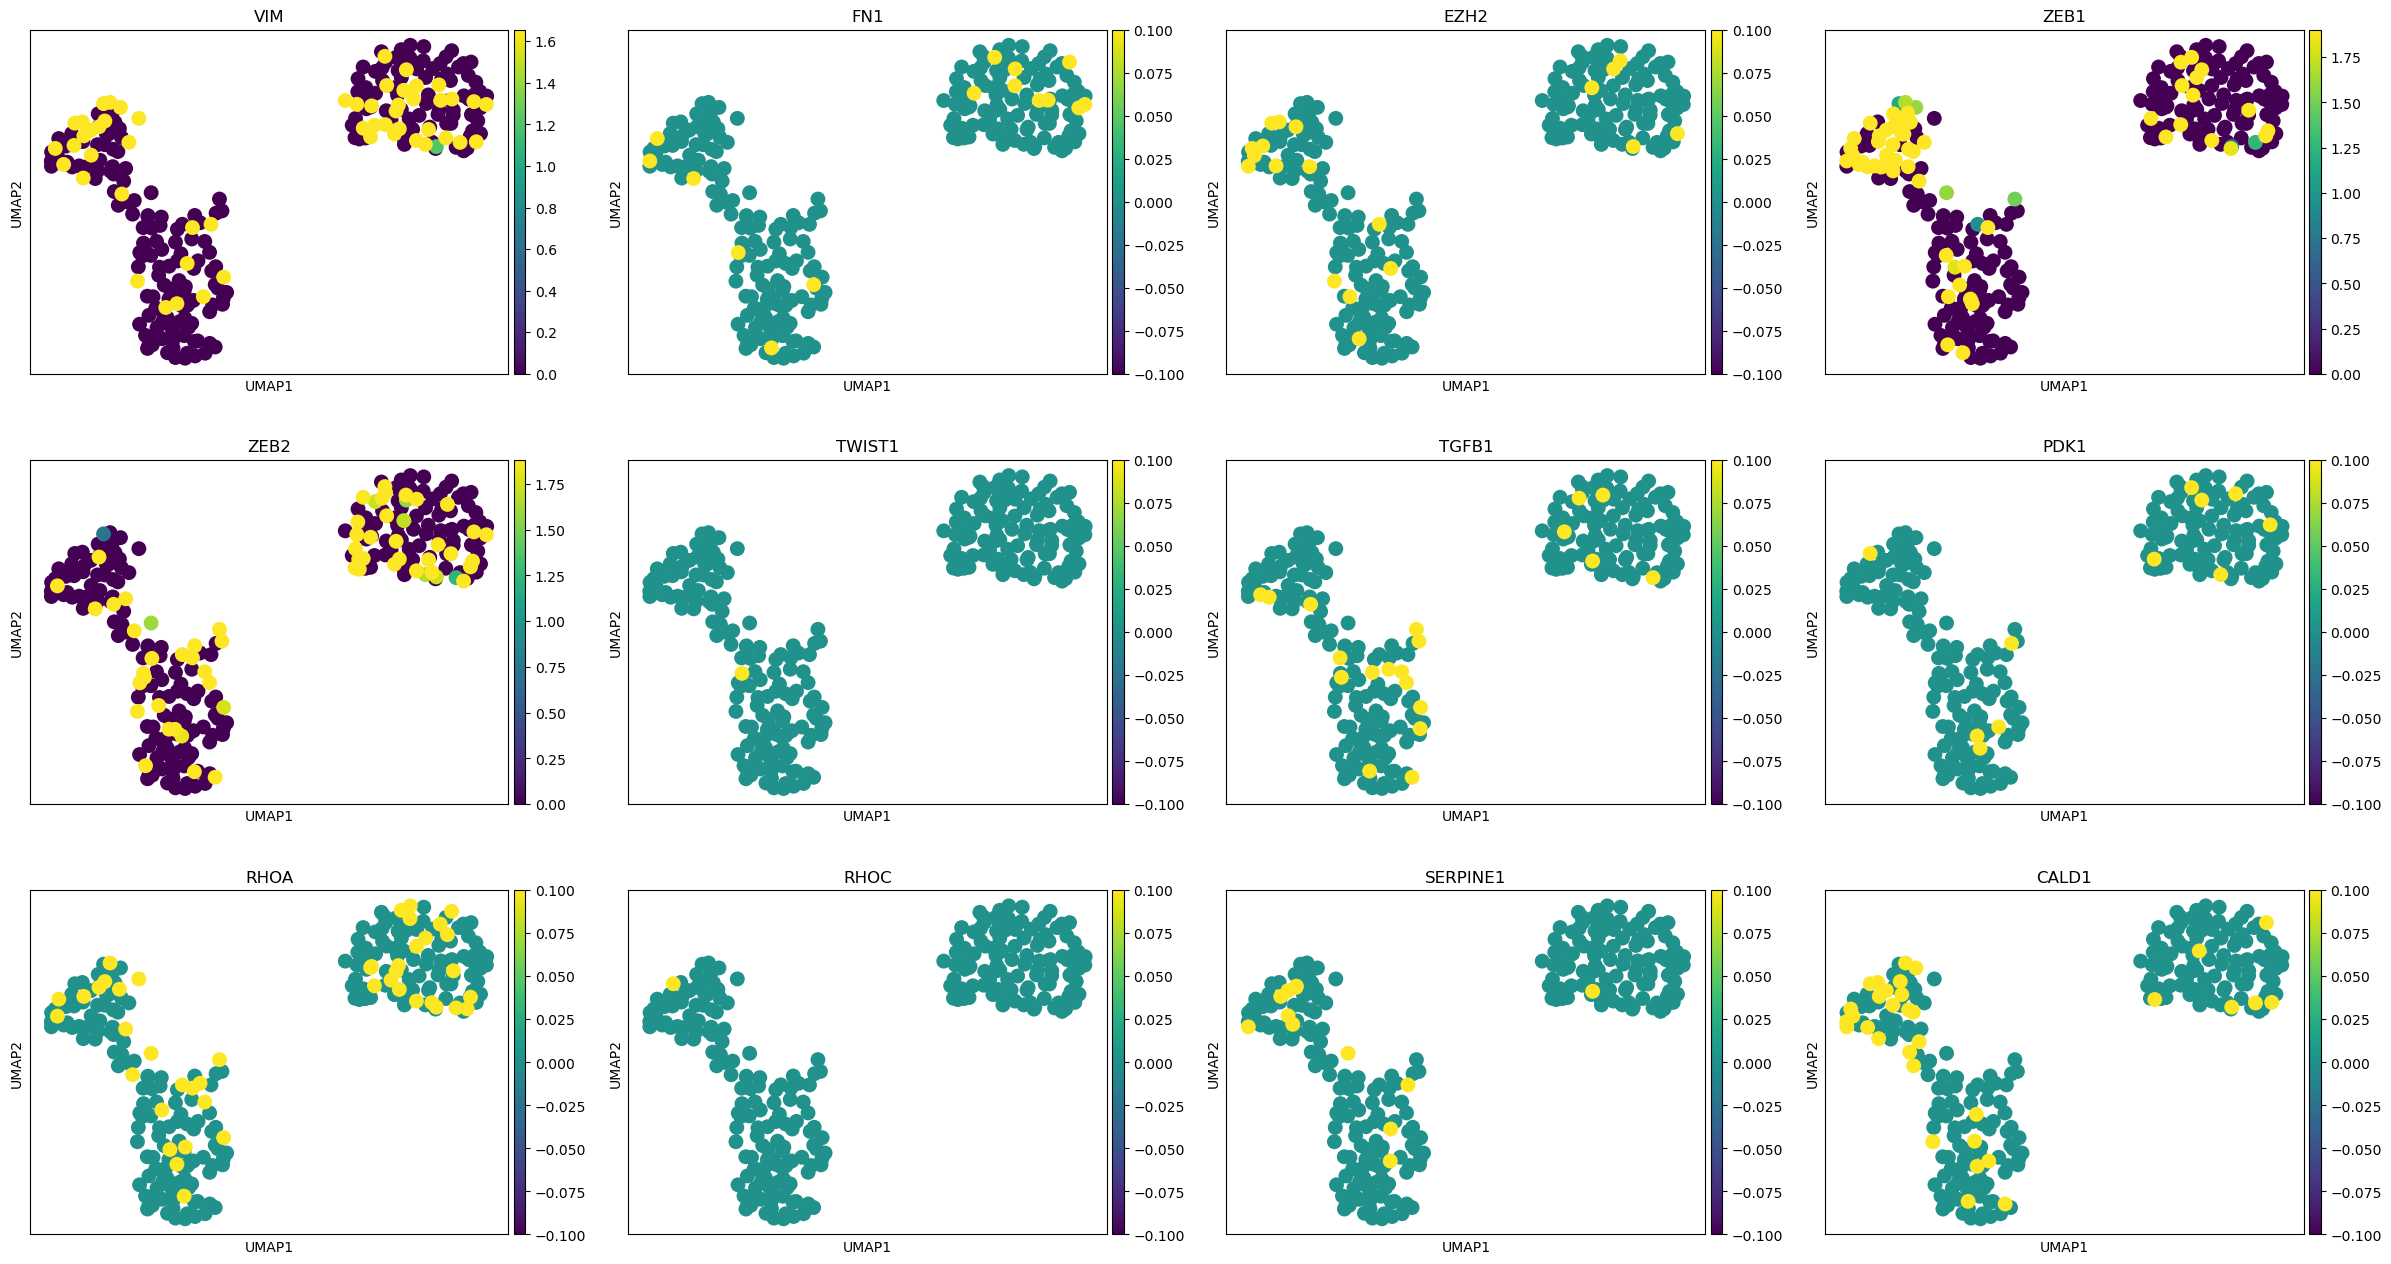

In [41]:
emt_genes = ['VIM', 'FN1', 'EZH2', 'ZEB1', 'ZEB2', 'TWIST1', 'TGFB1', 'PDK1', 'RHOA', 'RHOC', 'SERPINE1', 'CALD1']
sc.pl.umap(ctc, color=emt_genes, vmax='p80', vmin='p10')

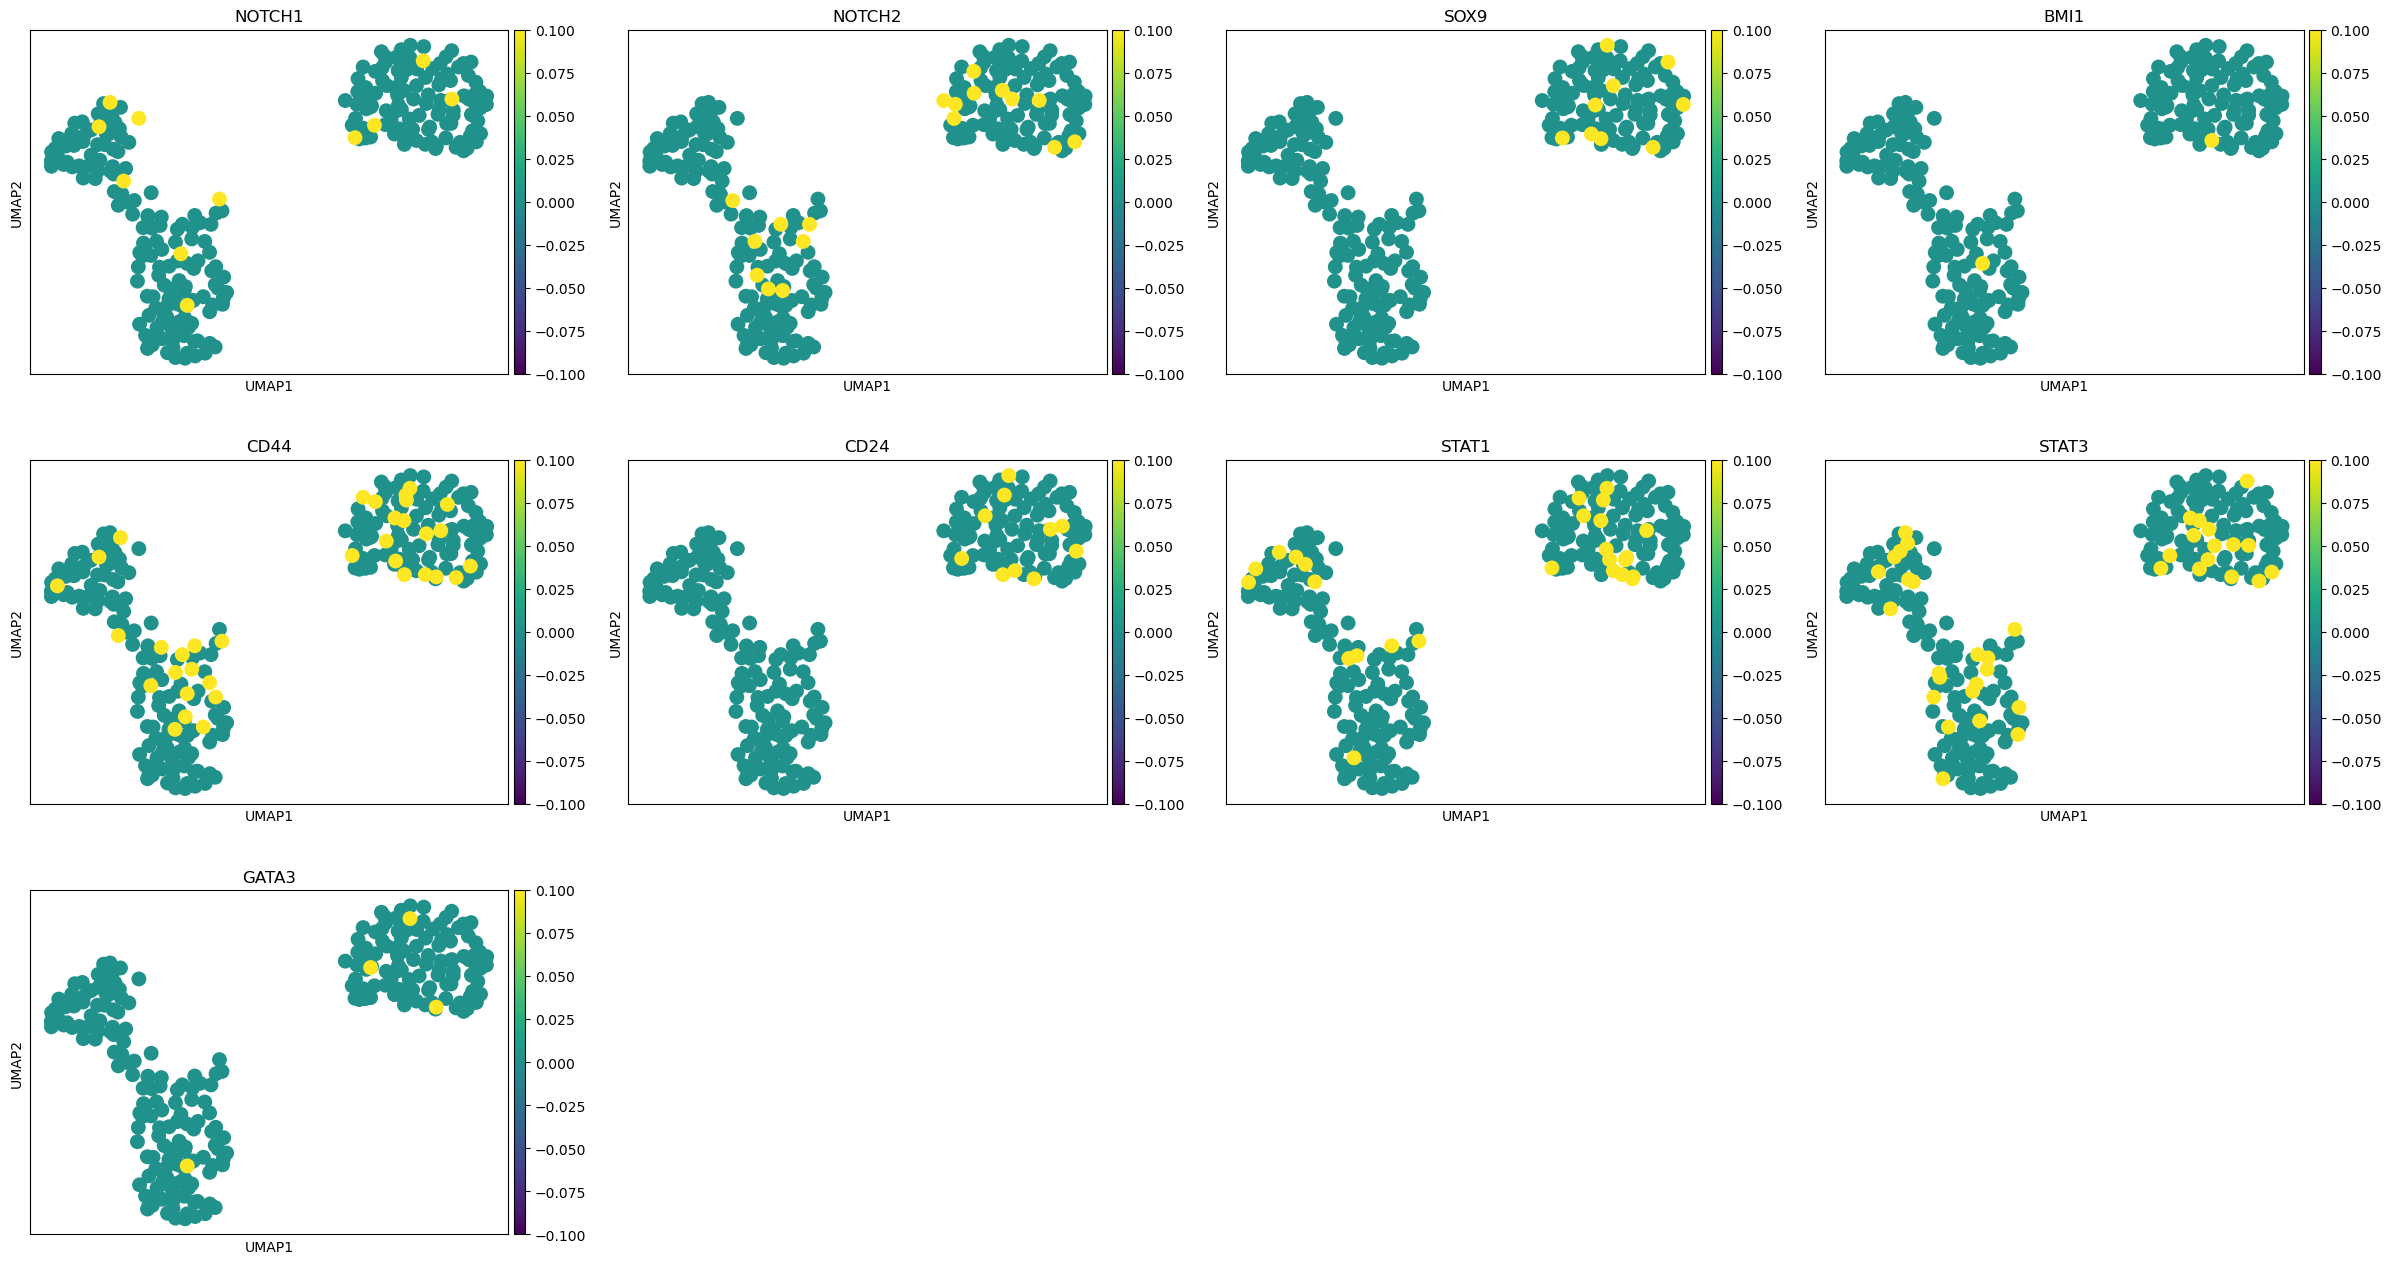

In [42]:
csc_genes = ['NOTCH1', 'NOTCH2', 'SOX9', 'BMI1', 'CD44', 'CD24', 'STAT1', 'STAT3', 'GATA3']
sc.pl.umap(ctc, color=csc_genes, vmax='p80', vmin='p10')

In [40]:
ctc

AnnData object with n_obs × n_vars = 261 × 12557
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno', 'chip_color', 'anno_ctc', 'ctc_heteogeneity', 'Program_1', 'Program_2', 'Program_3', 'Program_4', 'Program_5'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_colors', 'anno_ctc_colors', 'chip_id_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap', 'nmf_H'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_nmf'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [42]:
H_df = pd.DataFrame(H, columns=ctc.var_names, index=[f"Program_{i+1}" for i in range(H.shape[0])])

In [70]:
top_p1 = H_df.loc["Program_4"].sort_values(ascending=False).head(50).index.tolist()

enr = gp.enrichr(gene_list=top_p1,
                     gene_sets='KEGG_2021_Human',
                     organism='Human',
                     outdir=None)

In [71]:
enr.res2d.to_csv('/mnt/c/Users/ouyangkang/Desktop/Program_4_KEGG.csv')

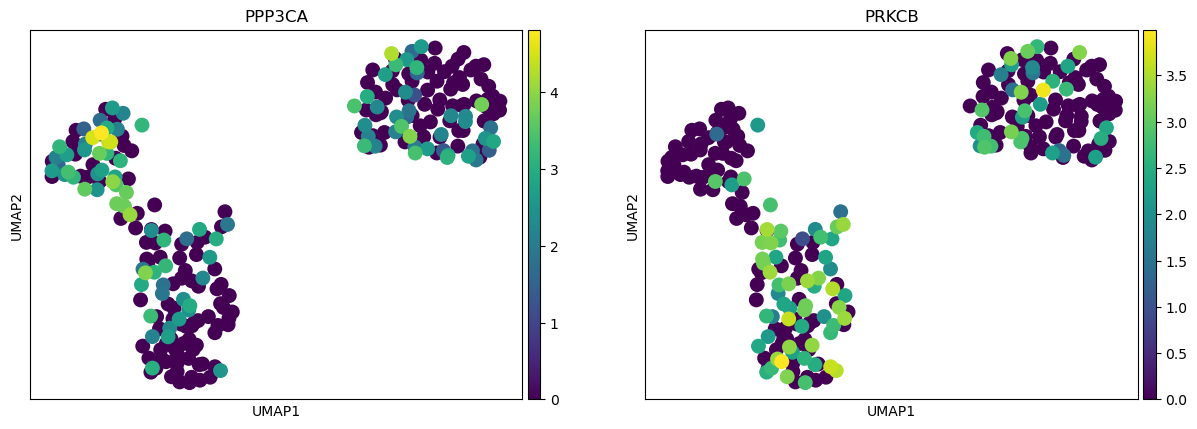

In [72]:
sc.pl.umap(ctc, color=['PPP3CA', 'PRKCB'])

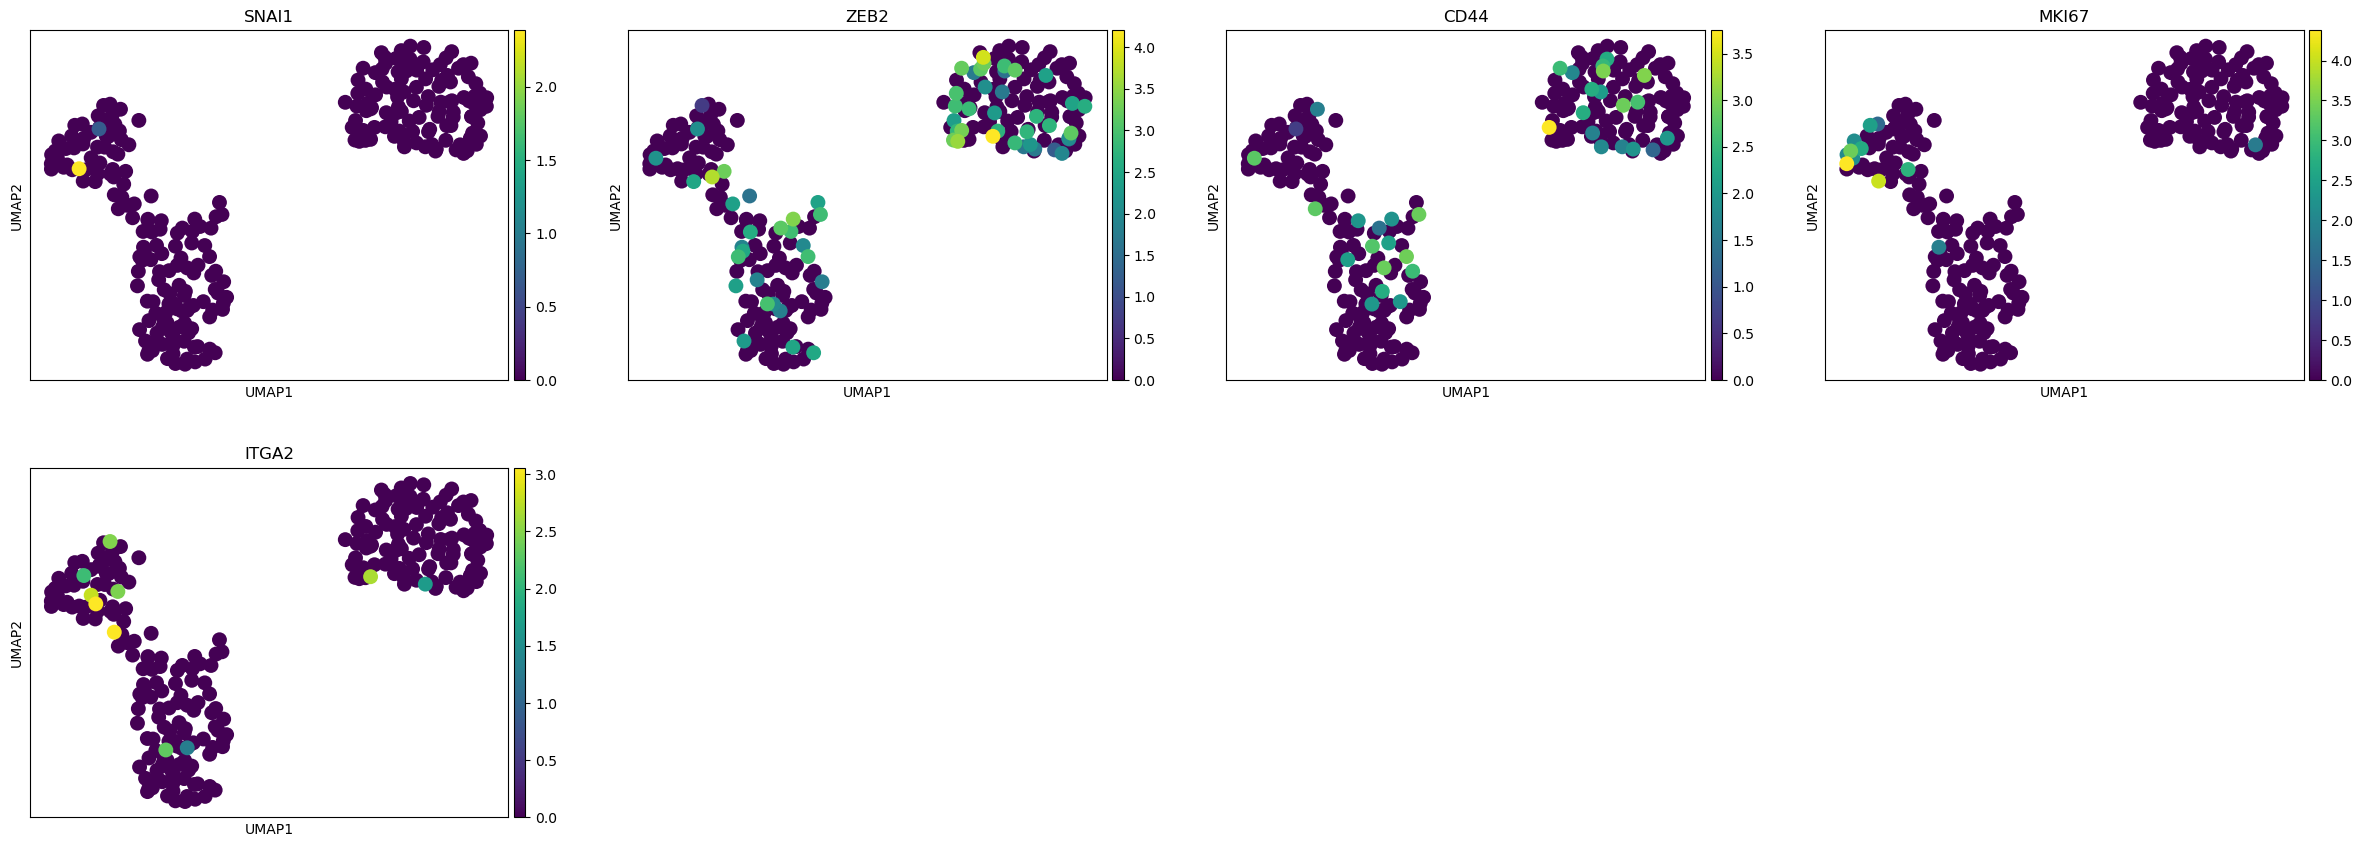

In [76]:
sc.pl.umap(ctc, color=['SNAI1', 'ZEB2', 'CD44', 'MKI67', 'ITGA2'])

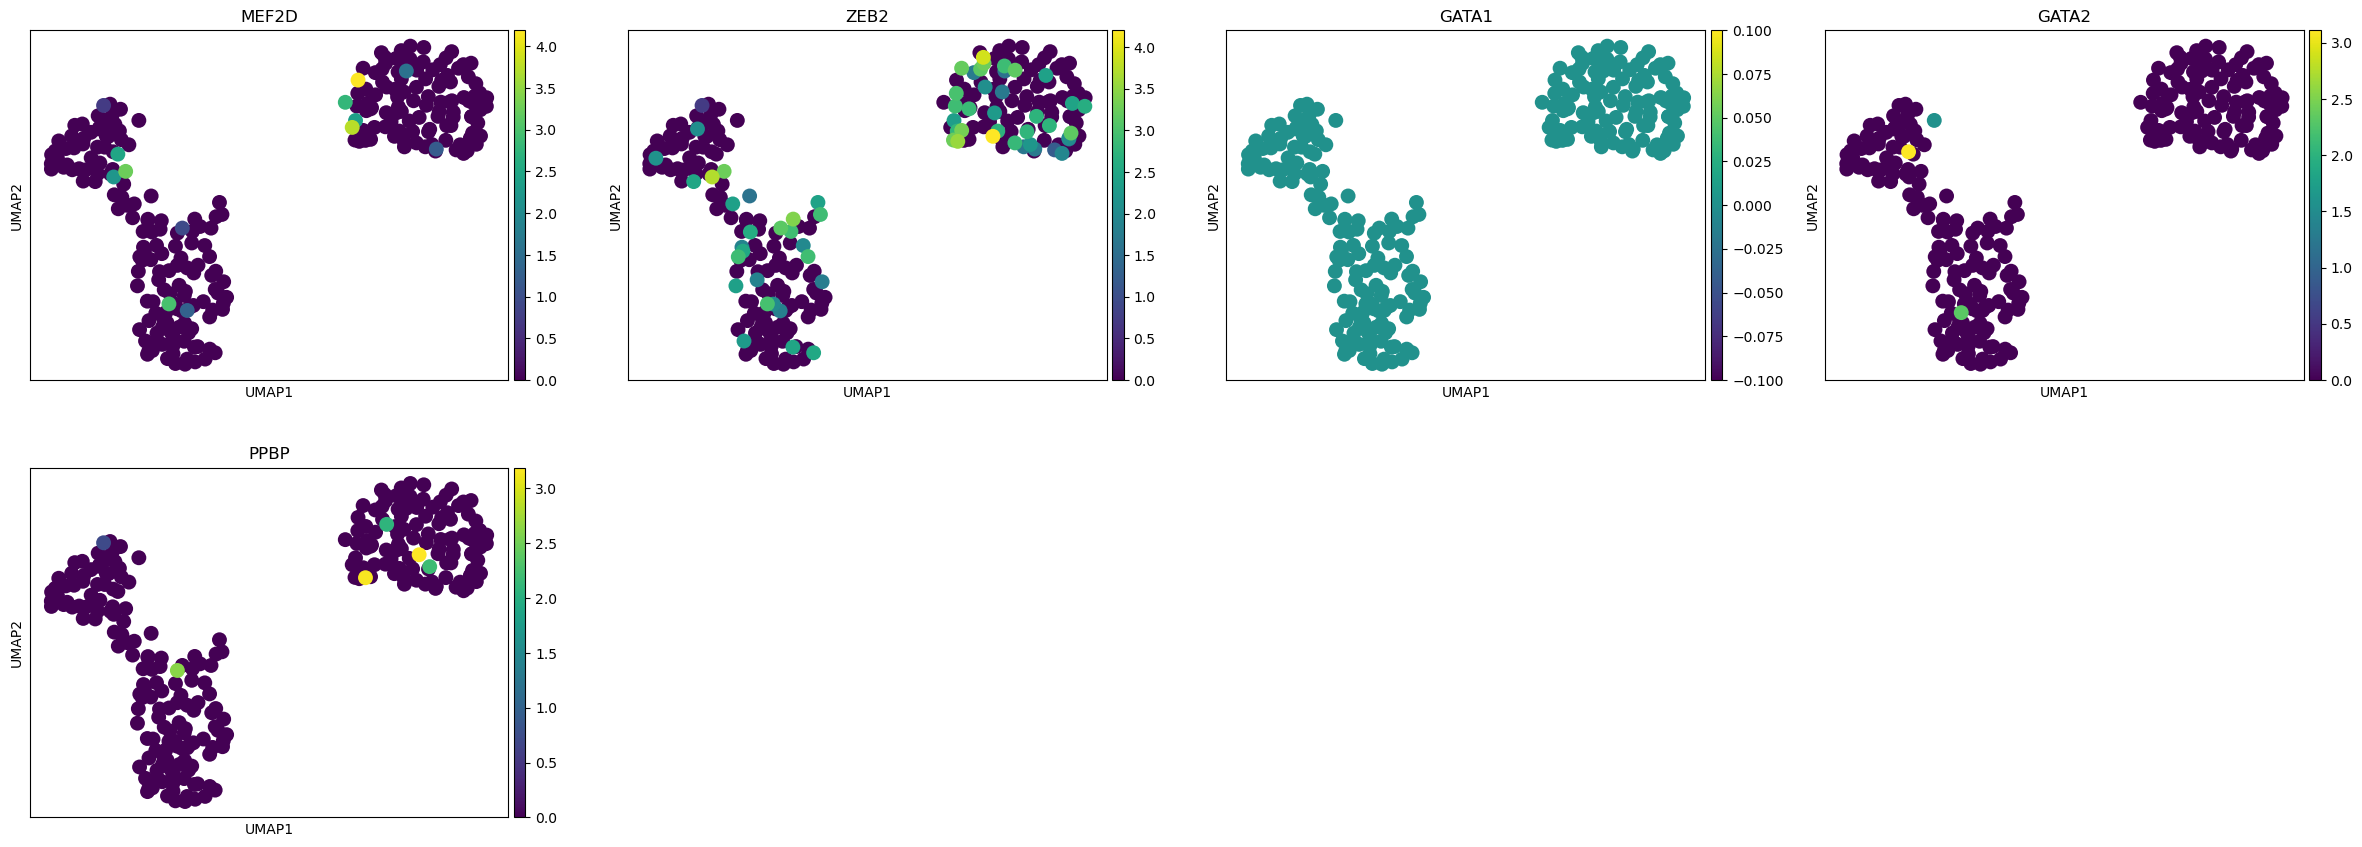

In [78]:
sc.pl.umap(ctc, color=['MEF2D', 'ZEB2', 'GATA1', 'GATA2', 'PPBP'])

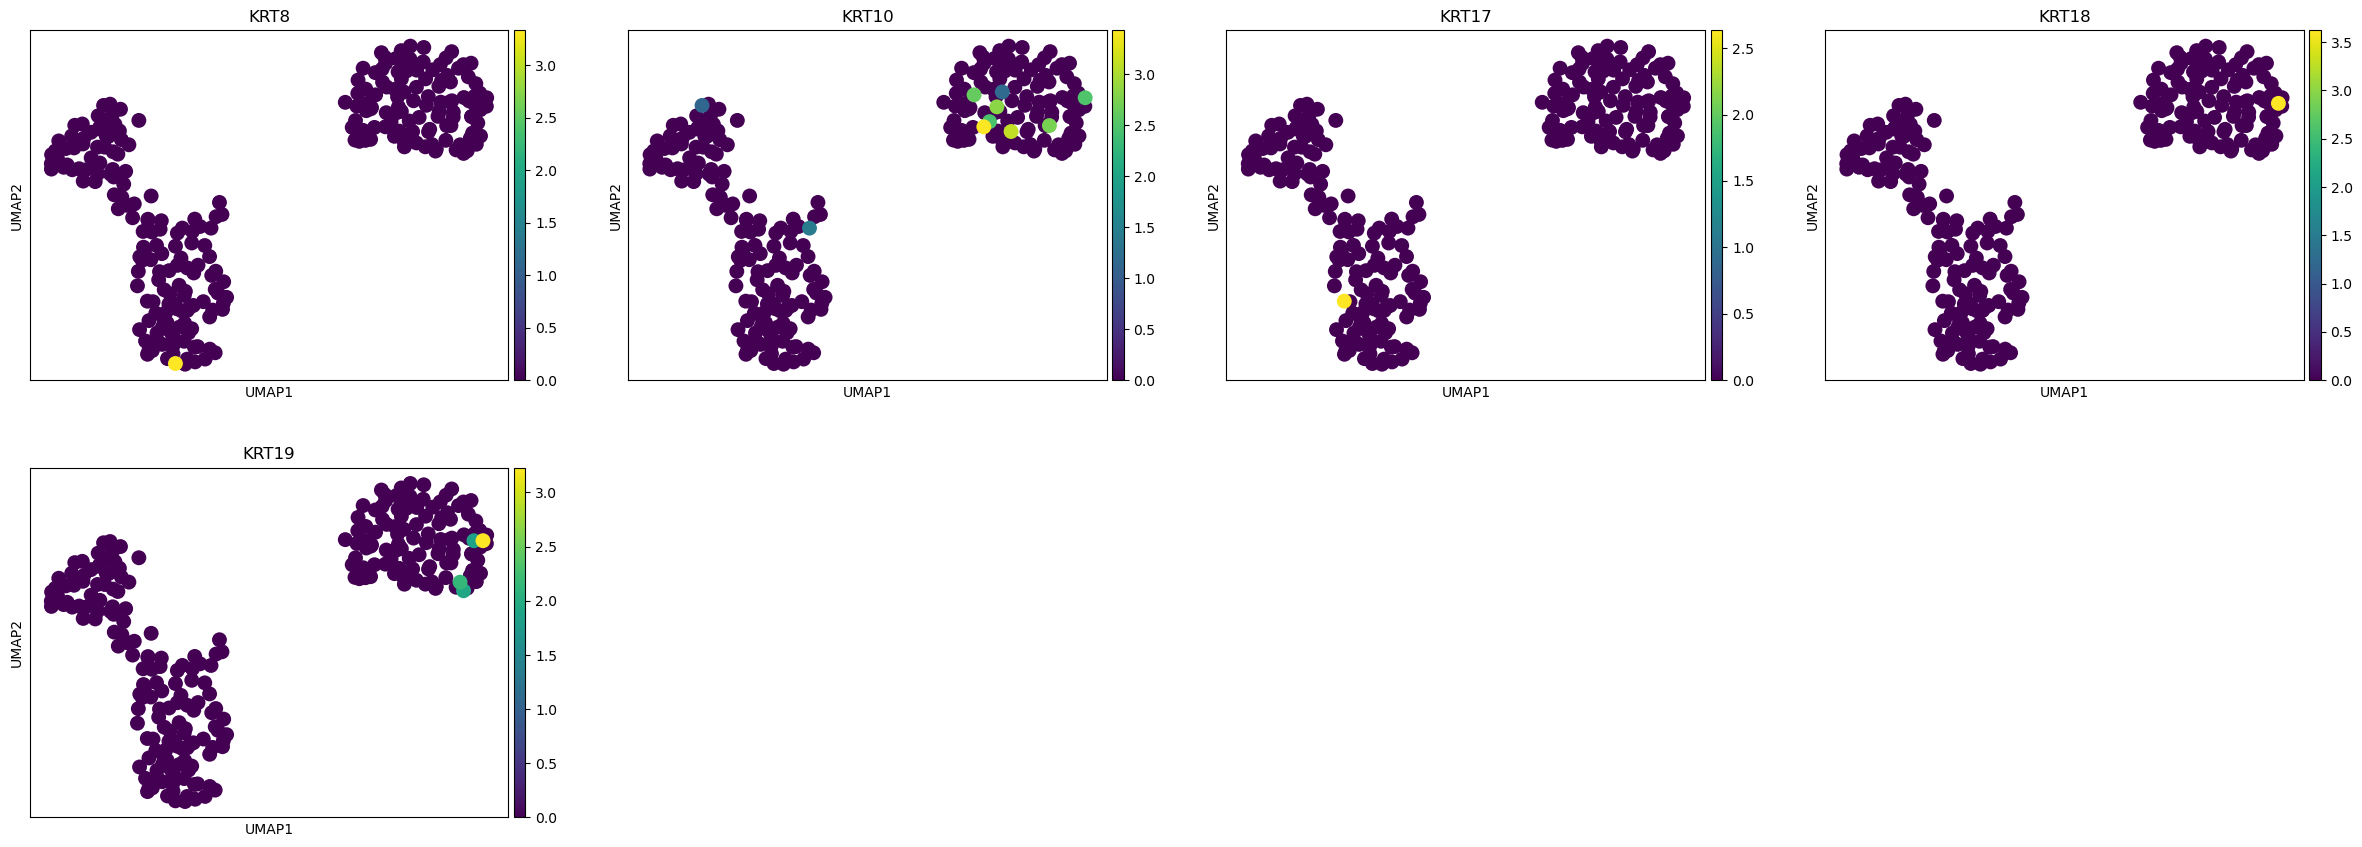

In [82]:
sc.pl.umap(ctc, color=['KRT8', 'KRT10', 'KRT17', 'KRT18', 'KRT19'])

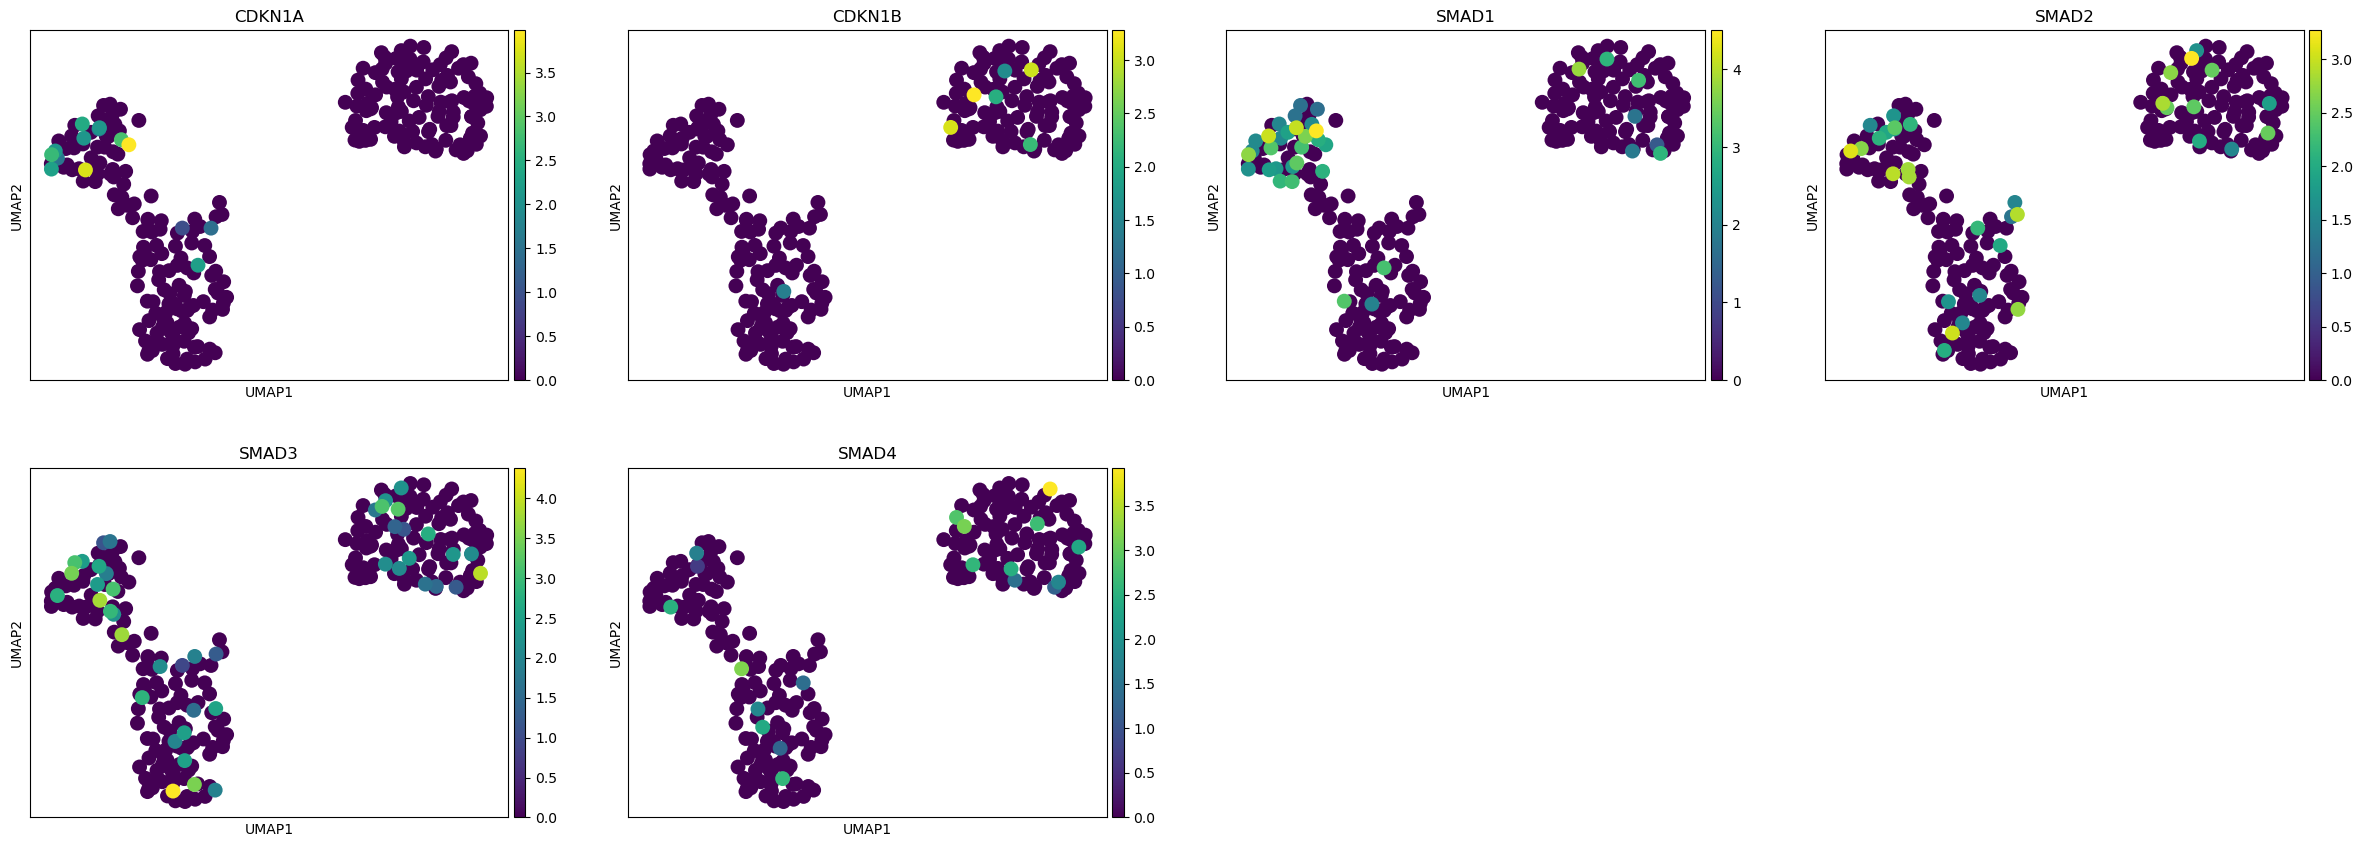

In [83]:
sc.pl.umap(ctc, color=['CDKN1A', 'CDKN1B', 'SMAD1', 'SMAD2', 'SMAD3', 'SMAD4'])

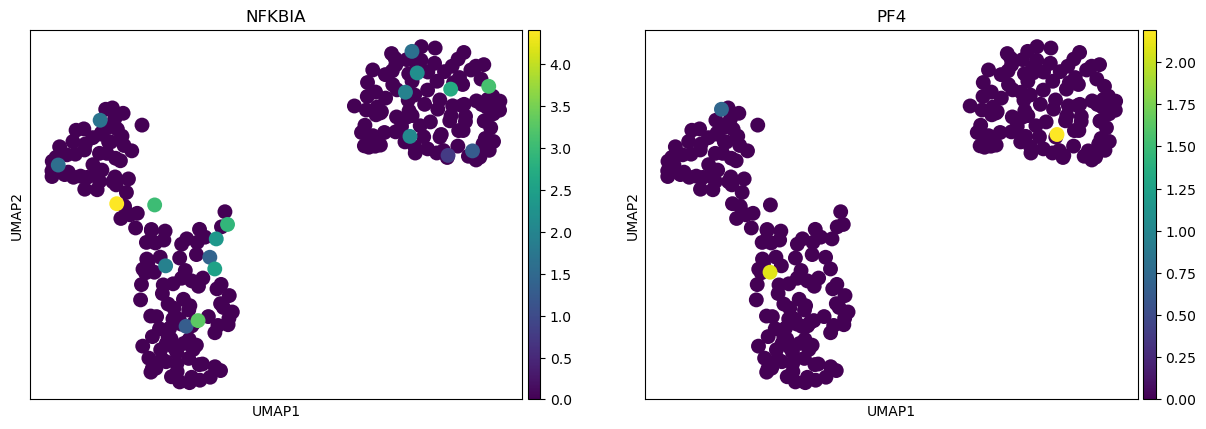

In [85]:
sc.pl.umap(ctc, color=['NFKBIA', 'PF4'])